In [1]:
import tensorflow as tf

import numpy as np
import glob
from matplotlib import pyplot as plt

# Convert code as saved model

In [46]:
model = tf.keras.models.load_model('weights/mobilnet_hd_func.h5', compile=False)

In [ ]:
model.summary()

In [ ]:
tf.saved_model.save(model, 'weights/mobilenet_hd')

# Load saved model

In [2]:
labels = {
    0: 'not hot dog',
    1: 'hot dog'
}

In [3]:
model = tf.saved_model.load('weights/mobilenet_hd/')

In [4]:
infer = model.signatures['serving_default']

In [5]:
images = glob.glob('data/test/**/*.jpg', recursive=True)

CPU times: user 724 ms, sys: 215 ms, total: 939 ms
Wall time: 476 ms


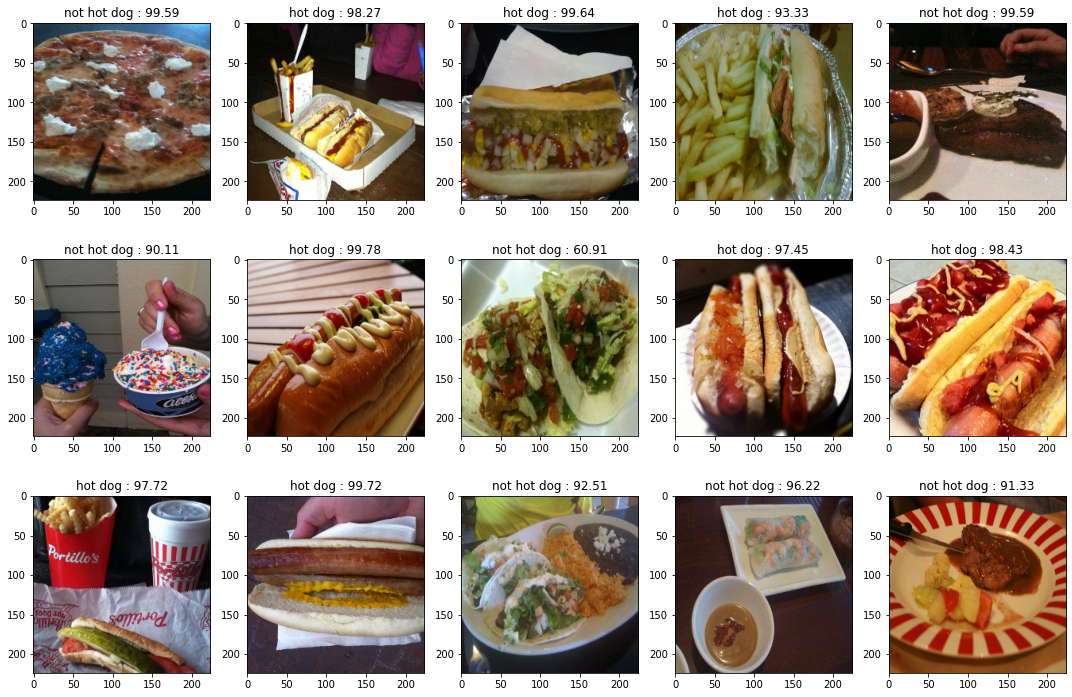

In [36]:
%%time
row, column, count = 3, 5, 0
plt.figure(figsize=(15, 10))
for image in np.random.choice(images, 15):
    img = tf.io.decode_jpeg(tf.io.read_file(image))
    img_pre = tf.cast(img, tf.float32) / 255.
    img_pre = tf.image.resize(img_pre, [224, 224])
    img_pre = tf.expand_dims(img_pre, axis=0)
    preds = infer(img_pre)['outputs']
    preds = tf.squeeze(preds, axis=0)
    
    label = labels[preds.numpy().argmax()]
    count += 1
    plt.subplot(row, column, count)
    plt.title(label + ' : ' + str(round(preds.numpy().max() * 100, 2)))
    img_ex = tf.squeeze(img_pre, axis=0) * 255
    plt.imshow(tf.cast(img_ex, tf.uint8))
    
plt.tight_layout()

# Save preprocessing as saved model

In [27]:
# @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None, 3], dtype=tf.uint8),))
# def preproc(img):
#     img = tf.cast(img, tf.float32) / 255.
#     img = tf.image.resize(img, [224, 224])
    
#     return img

class Preproc(tf.Module):
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, None, 3], dtype=tf.uint8),))
    def __call__(self, img):
        img = tf.cast(img, tf.float32) / 255.
        img = tf.image.resize(img, [224, 224])

        return img
    
preproc = Preproc()

In [40]:
tf.saved_model.save(preproc, 'weights/preproc')

INFO:tensorflow:Assets written to: weights/preproc/assets


In [41]:
preproc_model = tf.saved_model.load('weights/preproc/')

In [43]:
prepoc = preproc_model.signatures['serving_default']

CPU times: user 565 ms, sys: 86.7 ms, total: 652 ms
Wall time: 462 ms


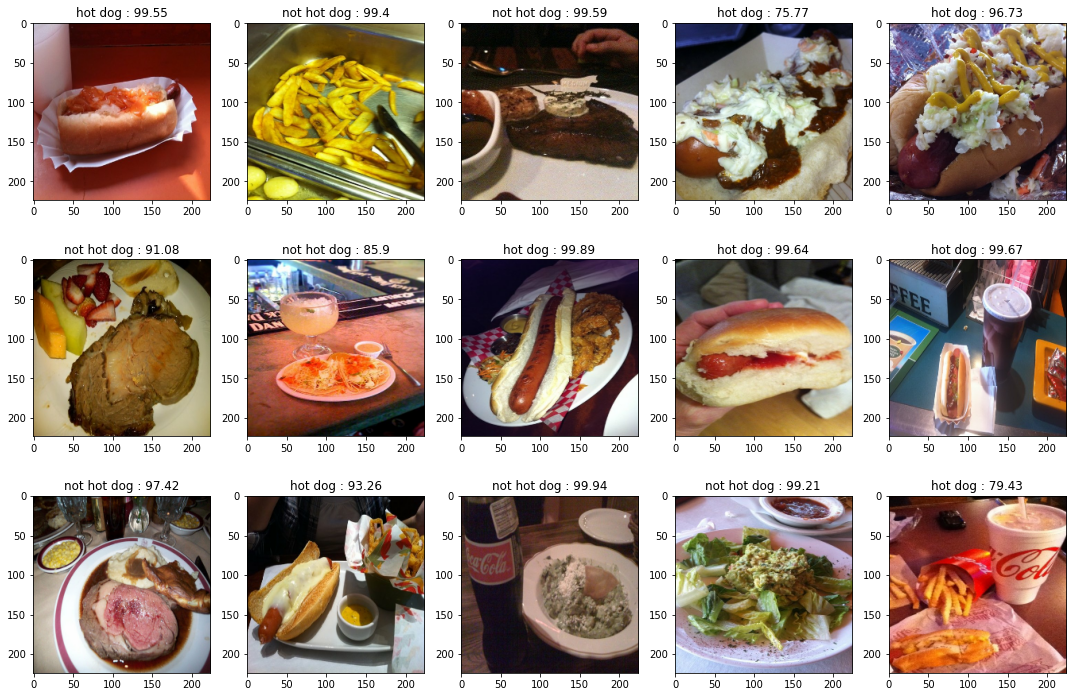

In [44]:
%%time
row, column, count = 3, 5, 0
plt.figure(figsize=(15, 10))
for image in np.random.choice(images, 15):
    img = tf.io.decode_jpeg(tf.io.read_file(image))
    
    img_pre = preproc(tf.expand_dims(img, axis=0))
    preds = infer(img_pre)['outputs']
    preds = tf.squeeze(preds, axis=0)
    
    label = labels[preds.numpy().argmax()]
    count += 1
    plt.subplot(row, column, count)
    plt.title(label + ' : ' + str(round(preds.numpy().max() * 100, 2)))
    img_ex = tf.squeeze(img_pre, axis=0) * 255
    plt.imshow(tf.cast(img_ex, tf.uint8))
    
plt.tight_layout()